# Bayesian Parameter Estimation

In [1]:
import os
import glob
import pickle

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special
import scipy.optimize
import scipy.stats as st
import statsmodels.tools.numdiff as smnd
import emcee
import numba

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner

# Set the plotting style.
import sys
sys.path.insert(0, '../')
import mwc_mutants_utils as mwc
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

#### $\LaTeX$ command definitions.
$\newcommand \foldchange{\operatorname{fold-change}}$

# Bayesian parameter estimation

In this notebook we will explore the problem of inferring the parameters related to the protein structure using Markov-Chain Monte Carlo (MCMC) to sample out of the posterior distribution of these parameters given the data.

First we know that the theoretical prediction for the fold-change in gene expression due to the presence of the transcriptional repressor for our simple repression architecture is given by
$$
\text{fold-change} = \frac{1}{1 + p_{act}(c) \frac{R}{N_{NS}}  e^{-\beta \Delta \varepsilon_{RA}}},
\tag{1}
$$

where $R$ is the number of repressors, $N_{NS}$ is the number of non-specific binding sites, $\Delta \varepsilon_{RA}$ is the repressor binding energy to the DNA, and $p_{act}(c)$, the probability of the repressor being in the active state as a function of the ligand concentration $c$ is given by
\begin{equation}
p_{act}(c) = \frac{\left( 1 + \frac{c}{c_o} e^{\tilde{k}_A}\right)^2}{\left( 1 + \frac{c}{c_o} e^{\tilde{k}_A}\right)^2 + e^{-\beta \Delta\varepsilon_{AI}} \left( 1 + \frac{c}{c_o} e^{\tilde{k}_I}\right)^2},
\tag{2}
\end{equation}
where $\Delta\varepsilon_{AI}$ is the energy difference between the active and the inactive state of the repressor, and $c_o$ is a reference concentration taken up to be 1 $M$. Both mathematically and numerically, it is convenient to define $\tilde{k}_A = -\log \frac{K_A}{c_o}$ and $\tilde{k}_I = -\log \frac{K_I}{c_o}$ and fit for these parameters on a log scale. Dissociation constants are scale invariant, so that a change from $10\,\mu\text{M}$ to $1\,\mu\text{M}$ leads to an equivalent increase in affinity as a change from $1\,\mu\text{M}$ to
$0.1\,\mu\text{M}$

If we want to infer the parameters out of Eq. 1 and 2 related to the protein structure, i.e. $\Delta\varepsilon_{RA}$, $\tilde{k}_A$, and/or $\tilde{k}_I$ we can write the probability distribution of the parameter values given the data $D$. This distribution is given by Bayes theorem as
\begin{equation}
	P(\Delta\varepsilon_{RA}, \tilde{k}_A, \tilde{k}_I \mid D) = \frac{P(D \mid \Delta\varepsilon_{RA}, \tilde{k}_A, \tilde{k}_I)P(\Delta\varepsilon_{RA}, \tilde{k}_A, \tilde{k}_I)}{P(D)},
\tag{3}
\end{equation}
where $D$ is composed by all the independent variables (repressor copy
number $R$, and inducer concentration $c$) and one dependent variable (experimental fold-change). $P(D \mid \Delta\varepsilon_{RA}, \tilde{k}_A, \tilde{k}_I)$ is the likelihood of having observed the data given the parameter values, $P(\Delta\varepsilon_{RA}, \tilde{k}_A, \tilde{k}_I)$ contains all the prior information on these parameters, and $P(D)$ serves as a normalization constant, which we can ignore in our parameter estimation. Eq. 1 and 2 assume a deterministic relationship between the parameters and the data, so in order to construct a probabilistic relationship as required by Eq. 3, we assume that the experimental fold-change for the $i^\text{th}$ datum given the parameters is of the form
\begin{equation}
\text{fold-change}_{\exp}^{(i)} = \left( 1 + \frac{\left(1 +
\frac{c^{(i)}}{c_o}e^{\tilde{k}_A}\right)^2}{\left( 1 + \frac{c^{(i)}}{c_o}e^{\tilde{k}_A}\right)^2 +
e^{-\beta \Delta \varepsilon_{AI}} \left(1 +  \frac{c^{(i)}}{c_o}e^{\tilde{k}_I} \right)^2} \frac{R^{(i)}}{N_{NS}} e^{-\beta
\Delta \varepsilon_{RA}}\right)^{-1} + \epsilon^{(i)},
\tag{4}
\end{equation}
where $\epsilon^{(i)}$ represents the departure from the deterministic
theoretical prediction for the $i^\text{th}$ data point. If we assume that these
$\epsilon^{(i)}$ errors are normally distributed with mean zero and standard
deviation $\sigma$, the likelihood of the data given the parameters is of the
form
\begin{equation}
P(D \mid \Delta\varepsilon_{RA}, \tilde{k}_A, \tilde{k}_I, \sigma) =
\frac{1}{(2\pi\sigma^2)^{\frac{n}{2}}}\prod\limits_{i=1}^n \exp
\left[-\frac{(\foldchange^{(i)}_{\exp} - \foldchange(\tilde{k}_A, \tilde{k}_I, R^{(i)},
\Delta\varepsilon_{RA}^{(i)}, \frac{c^{(i)}}{c_o}))^2}{2\sigma^2}\right],
\tag{5}
\end{equation}
where $\foldchange^{(i)}_{\text{exp}}$ is the experimental fold-change and
$\foldchange(\,\cdots)$ is the theoretical prediction. The product $\prod_{i=1}^n$
captures the assumption that the $n$ data points are independent. Note that the
likelihood and prior terms now includes the extra unknown parameter $\sigma$. In
applying Eq. 5, a choice of $\tilde{k}_A$ and $\tilde{k}_I$ that provides better
agreement between theoretical fold-change predictions and experimental
measurements will result in a higher value likelihood value.

In addition, we assume a uniform distribution for $\tilde{k}_A$ and
$\tilde{k}_I$ and a Jeffreys prior for the scale parameter $\sigma$. This yields the complete prior
\begin{equation}
P(\tilde{k}_A, \tilde{k}_I, \sigma) \equiv \frac{1}{(\tilde{k}_A^{\max} -
\tilde{k}_A^{\min})} \frac{1}{(\tilde{k}_I^{\max} -
\tilde{k}_I^{\min})}\frac{1}{\sigma}.
\tag{6}
\end{equation}

These priors are maximally uninformative meaning that they imply no prior knowledge of the parameter values.

### The MCMC approach to the problem.

We will now use MCMC to sample out of this distribution to fit for the 3 parameters. For this we need to define functions to compute the log probability.

In [2]:
def pact(iptg, ka, ki, epsilon=4.5, n=2):
    '''
    Returns the probability of a repressor bking active as described
    by the MWC model.

    Parameter
    ---------
    iptg : array-like.
        Concentrations of inducer on which to evaluate the function.
        All values must be positive.
    ka, ki : float.
        Minus log of the dissociation constants of the active and the
        inactive states respectively.
    epsilon : float.
        Positive log of the energy difference between the active and the
        inactive state.
    n : int
        Number of inducer binding sites.
    Returns
    -------
    pact : float.
        probability of a repressor of bking in the active state.
        Active state is defined as the state that can bind to the DNA.
    '''
    return (1 + iptg * np.exp(ka))**n / ((1 + iptg * np.exp(ka))**n +\
                      np.exp(-epsilon) * (1 + iptg * np.exp(ki))**n)

def fold_change(iptg, ka, ki, epsilon, R, epsilon_RA, n=2,
                    quaternary_state=1, nonspec_sites=4.6E6):
    '''
    Returns the gene expression fold change according to the
    thermodynamic model with the extension that takes into account the
    effect of the inducer.

    Parameter
    ---------
    iptg : array-like.
        Concentrations of inducer on which to evaluate the function
    ka, ki : float.
        Minus log of the dissociation constants of the active and the
        inactive states respectively
    epsilon : float.
        Energy difference between the active and the inactive state
    R : array-like.
        Repressor copy number for kach of the strains. The length of
        this array should be equal to the iptg array. If only one value
        of the repressor is given it is asssume that all the data points
        should be evaluated with the same repressor copy number
    epsilon_RA : array-like
        Repressor binding energy. The length of this array
        should be equal to the iptg array. If only one value of the
        binding energy is given it is asssume that all the data points
        should be evaluated with the same repressor copy number
    quaternary_state: int
        Prefactor in front of R in fold-change. Default is 2
        indicating that there are two functional hkads per repressor molecule.
        This value must not be zero.
    nonspec_sites : int
        Number of nonspecific binding sites in the system.
        This value must be grkater than 0.

    Returns
    -------
    fold_change : float.
        Gene expression fold change as dictated by the thermodynamic model.
    '''
    return (1 + quaternary_state * R / nonspec_sites *
            pact(iptg, ka, ki, epsilon, n) * (1 + np.exp(-epsilon)) *
            np.exp(-epsilon_RA))**-1

In [3]:
def log_likelihood(param, param_names, indep_var, fc_exp):
    """
    Computes the log likelihood probability.
    Parameteres
    -----------
    param : array-like.
        The parameters to be fit by the MCMC. For this function there are 4
        possible parameters that the routine can fit:
        1. epsilon_RA
        2. ka == -lnKa
        3. ki == -lnKi
        4. epsilon
        5. R
        6. sigma : Homoscedastic error associated with the Gaussian likelihood.
           NOTE: This parameter ALWAYS has to be included.
        Any of these parameters can be fit in any combination as long as the names
        are indicated in in the param_names array. But for these the parameters
        must be fed in the same order as indicated in the param_names array.
    param_names : array-like.
        array containing strings with the names of the parameters given in the
        param array. NOTE: It is important that these names are given in the same
        order as the in the param array.
    indep_var : dictionary.
        series of independent variables to compute the theoretical fold-change.
        These array MUST contain all the variables necessary to compute the
        theoretical fold-change that were not indicated in the param array.
    fc_exp : array-like.
        experimental fold change of each of the data points.
    Returns
    -------
    log_like : float.
        the log likelihood.
    """
    # Generate dictionary with the given parameters to compute the theoretical
    # fold change.
    fc_param = {**dict(zip(param_names, param)), **indep_var}
    
    # Make a dictionary with the parameters that are needed to compute the 
    # theoretical fold-change only
    fc_dict = {key: value for key, value in fc_param.items() \
                if key in fold_change.__code__.co_varnames}
    
    # compute the theoretical fold-change
    fc_theory = fold_change(**fc_dict)
   
    log_like =  np.sum((fc_theory - fc_exp)**2) / 2 / fc_param['sigma']**2
    return log_like
   
def log_post(param, param_names, indep_var, fc_exp, bounds):
    """
    Computes the log likelihood probability.
    Parameteres
    -----------
    param : array-like.
        The parameters to be fit by the MCMC. For this function there are 4
        possible parameters that the routine can fit:
        1. epsilon_RA
        2. ka == -lnKa
        3. ki == -lnKi
        4. epsilon
        5. R
        6. sigma : Homoscedastic error associated with the Gaussian likelihood.
           NOTE: This parameter ALWAYS has to be included.
        Any of these parameters can be fit in any combination as long as the names
        are indicated in in the param_names array. But for these the parameters
        must be fed in the same order as indicated in the param_names array.
            NOTE: ALL THE PARAMETERS ARE ASSUMED TO HAVE A UNIFORM PRIOR AND
            THE BOUNDARIES FOR SUCH PRIORS ARE GIVEN IN THE bounds DICTIONARY.
    param_names : array-like.
        array containing strings with the names of the parameters given in the
        param array. NOTE: It is important that these names are given in the same
        order as the in the param array.
    indep_var : dictionary.
        series of independent variables to compute the theoretical fold-change.
        These array MUST contain all the variables necessary to compute the
        theoretical fold-change that were not indicated in the param array.
    fc_exp : array-like.
        experimental fold change of each of the data points.
    bounds : dictionary.
        All of the parameters given in param are assumed to have a uniform prior.
        This dictionary contains all the bounds on these parameters.
    Returns
    -------
    log_like : float.
        the log likelihood.
    """
    # Generate dictionary with the given parameters to check the boundaries
    param_dict = dict(zip(param_names, param))
    
    # loop through the parameters and check the boundaries
    prior = [np.min(bounds[p]) <= param_dict[p] <= np.max(bounds[p]) \
             for p in param_names[:-1]]
    
    # Return -inf if one of the boundaries is not satisfied
    # or if sigma is negative
    if not np.all(prior) or param_dict['sigma'] < 0:
        return -np.inf
    
    return -(len(indep_var['iptg']) + 1) * np.log(param_dict['sigma'])\
    - log_likelihood(param, param_names, indep_var, fc_exp)

## Testing the functions

Having defined these functions let's estimate the parameters for one of the strains to make sure everything works.

Let's first read the data.

In [29]:
# Read the CSV file with the mean fold change
df = pd.read_csv('../../data/flow_master.csv',index_col=0 , comment='#')
df = df[(df.strain!='auto') & (df.strain!='delta')]

# Remove O1 Y20I for now
df = df[np.invert((df.operator=='O1') & (df.strain=='Y20I'))]
df.head()

,date,username,operator,class,strain,repressors,IPTG_uM,mean_YFP,mean_YFP_bgcorr,fold_change
24,20170303,mrazomej,O2,dna,Q21A,260,0.1,10207.801372,6061.418830,0.219585
25,20170303,mrazomej,O2,dna,Q21A,260,0.0,9536.491380,5220.269553,0.278905
26,20170303,mrazomej,O2,dna,Q21A,260,1000.0,20307.551849,16127.546380,0.970668
27,20170303,mrazomej,O2,dna,Q21A,260,100.0,19769.723730,15746.672950,0.913559
28,20170303,mrazomej,O2,dna,Q21A,260,10.0,10745.853106,6788.125747,0.369471


### Initializing walkers around the most likely parameters.

In order to speed up the burn in step we can initialize the walkers around the most likely parameters found via optimization. For this performs a non-linear regression to find the most likely parameters and then initialize the walkers around those parameter values.

We have defined a function that performs a non-linear regression in a single step, finding the most likely parameters directly. For more details on how this non-linear regression is performed please visit [this tutorial](https://rpgroup-pboc.github.io/mwc_induction/code/notebooks/SI_E_nonlinear_regression.html)

In [40]:
# Extract the data
df_example = df[(df.operator=='O1') & (df.strain=='Q21M')]

# Define the parameters to be fit
param_names = ['epsilon_RA', 'ka', 'ki']
# Initial guess for each parameter
p0 = np.array([-13, -np.log(139.59), -np.log(0.53)])

# Define the independent variables
indep_var = dict(zip(['iptg', 'R'], 
                     df_example[['IPTG_uM', 'repressors']].values.T))
indep_var['epsilon'] = 4.5

# Extract the experimental fold_change
fc_exp = df_example.fold_change.values

# Peroform non-linear regression to obtain MAP and covariance matrix
map_param, cov =  mwc.non_lin_reg(p0, param_names, indep_var, fc_exp)
print(map_param)
print(cov)

[-61.67663976  -5.0189008   23.08141618]
[[  1.29319213e+03  -3.68516804e-02  -6.46263315e+02]
 [ -3.68516804e-02   7.14237053e-03   2.40794181e-02]
 [ -6.46263315e+02   2.40794181e-02   3.22970092e+02]]


Let's look at how this parameters found from the non-linear regression look with the data.

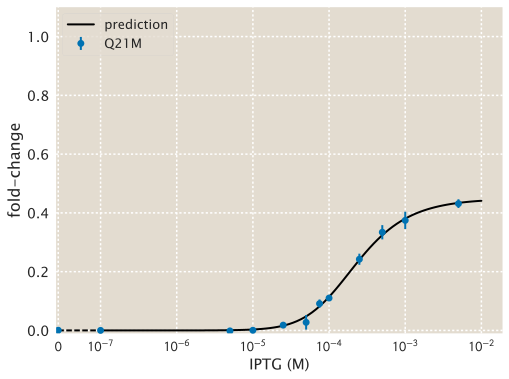

In [41]:
epsilon_RA, ka, ki = map_param
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-7, -2, 100)
IPTG_lin = np.array([0, 1E-7])

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# group data by unique strains
# extract the wt data for those sets
# compute the mean value for each concentration
fc_mean = df_example.groupby('IPTG_uM').fold_change.mean()
# compute the standard error of the mean
fc_err = df_example.groupby('IPTG_uM').fold_change.std() / \
np.sqrt(df_example.groupby('IPTG_uM').size())
ax.errorbar(np.sort(df_example.IPTG_uM.unique()) / 1E6,
        fc_mean, yerr=fc_err, fmt='o', 
        label=df_example.strain.unique()[0] , zorder=100)
# Plot theoretical prediction
# Log scale
ax.plot(IPTG, mwc.fold_change_log(IPTG * 1E6,
    ka=ka, ki=ki, epsilon=4.5,
    R=df_example.repressors.unique()[0],
    epsilon_RA=epsilon_RA),
    color='black', label='prediction')
# Linear scale
ax.plot(IPTG_lin, mwc.fold_change_log(IPTG_lin * 1E6,
    ka=ka, ki=ki, epsilon=4.5,
    R=df_example.repressors.unique()[0],
    epsilon_RA=epsilon_RA),
    linestyle='--', color='black', label=None)
ax.set_xscale('symlog', linthreshx=1E-7, linscalex=0.5)
ax.set_xlabel('IPTG (M)', fontsize=15)
ax.set_ylabel('fold-change', fontsize=16)
ax.set_ylim([-0.01, 1.1])
ax.set_xlim(left=-5E-9)
ax.tick_params(labelsize=14)
ax.legend(loc='upper left')


Let's now initialize the walkers for the MCMC run.

In [14]:
# Define the parameters to be fit
param_names = ['epsilon_RA', 'ka', 'ki', 'sigma']
# Define parameter boundaries for the prior
bounds = np.array([[-20, 0], [-10, 10], [-10, 10]])
bounds = dict(zip(param_names[:-1], bounds))
# Define the independent variables
indep_var = dict(zip(['iptg', 'R'], 
                     df_example[['IPTG_uM', 'repressors']].values.T))
indep_var['epsilon'] = 4.5

n_dim = len(param_names) # number of parameters
n_walkers = 50 # number of walkers
n_burn = 250 # number of steps for burn in
n_steps = 5000 # number of steps for MCMC

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:, range(len(param_names) - 1)] = np.random.multivariate_normal(map_param, 
                                                                   cov, n_walkers)
p0[:, -1] = np.random.uniform(1E-5, 0.2, n_walkers)

# Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
            args=(param_names, indep_var, fc_exp, bounds), threads=6)

And now we run the MCMC.

In [15]:
sample = True
if sample:
    #Do the burn in 
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    filename = '{0:s}_{1:.0f}_{2:s}.csv'.format(df_example.operator.unique()[0],
                                        df_example.repressors.unique()[0],
                                        df_example.strain.unique()[0])
    _ = sampler.run_mcmc(pos, n_steps)
    df_mcmc = pd.DataFrame(sampler.flatchain, columns=param_names)
    df_mcmc['Ka'] = np.exp(-df_mcmc['ka'])
    df_mcmc['Ki'] = np.exp(-df_mcmc['ki'])
    df_mcmc['lnprob'] = sampler.flatlnprobability
    df_mcmc.to_csv('../../data/mcmc/epsilonRA_ka_ki/' + filename)

Let's look at the corner plot for all parameters we care about.

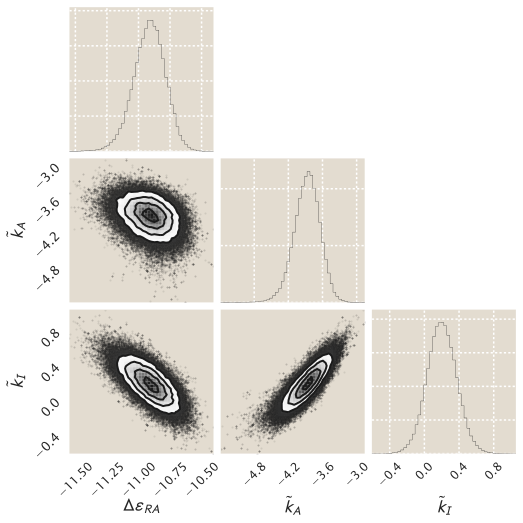

In [16]:
# Load the flat-chain
filename = '{0:s}_{1:.0f}_{2:s}.csv'.format(df_example.operator.unique()[0],
                                        df_example.repressors.unique()[0],
                                        df_example.strain.unique()[0])
df_mcmc = pd.read_csv('../../data/mcmc/epsilonRA_ka_ki/' + filename, index_col=0)

# Draw the corner plot
chain = df_mcmc[['epsilon_RA', 'ka', 'ki']].values
fig = corner.corner(chain, bins=50, plot_contours=True,
                   labels=[r'$\Delta\varepsilon_{RA}$', r'$\tilde{k}_A$', 
                           r'$\tilde{k}_I$'])

In [17]:
# map value of the parameters
max_idx = np.argmax(df_mcmc.lnprob.values, axis=0)
epsilon_r, ka, ki, sigma, Ka, Ki, lnprob = df_mcmc.ix[max_idx, :]

# ka range
epsilon_hpd = mwc.hpd(df_mcmc.ix[:, 0], 0.95)
Ka_hpd = mwc.hpd(df_mcmc.Ka.values, 0.95)
Ki_hpd = mwc.hpd(df_mcmc.Ki.values, 0.95)

# Print results
print("""
The most probable parameters for the model
------------------------------------------
epsilon_RA = {0:.2f} -{1:0.2f} +{2:0.2f} kBT
Ka = {3:.2f} -{4:0.2f} +{5:0.2f} µM
Ki = {6:.2f} -{7:0.3f} +{8:0.3f} µM
""".format(epsilon_r, np.abs(epsilon_r-epsilon_hpd[0]),\
           np.abs(epsilon_r-epsilon_hpd[1]),\
           Ka, np.abs(Ka-Ka_hpd[0]), np.abs(Ka-Ka_hpd[1]),\
           Ki,np.abs(Ki-Ki_hpd[0]), np.abs(Ki-Ki_hpd[1])))


The most probable parameters for the model
------------------------------------------
epsilon_RA = -10.91 -0.26 +0.23 kBT
Ka = 46.88 -17.33 +26.66 µM
Ki = 0.82 -0.256 +0.294 µM



# Systematically perform the MCMC for all strains

Now that we have all the infrastructure let's perform the MCMC for all the strains, including the WT. We will save the chains as a tidy data frame in `.csv` format.

First let's perform the linear regressions for all parameter sets.

In [32]:
# Group data frame by operator and strain
df_group = df.groupby(['operator', 'repressors', 'strain'])
param_names = ['epsilon_RA', 'ka', 'ki', 'sigma']

# extract the group names
groups = [g[0] for g in df_group]

# initalize dictionaries to save results
map_list = list()
cov_list = list()
for group, data in df_group:
    print(group)
    # Define the independent variables
    indep_var = dict(zip(['iptg', 'R'], 
                         data[['IPTG_uM', 'repressors']].values.T))
    indep_var['epsilon'] = 4.5
    # Extract the experimental fold-changes
    fc_exp = data.fold_change.values
    # Initial guess
    if group[0] == 'O1':
        p0 = np.array([-15, -np.log(139.59), -np.log(0.53)])
    elif group[0] == 'O2':
        p0 = np.array([-13, -np.log(139.59), -np.log(0.53)])    
    # Peroform non-linear regression to obtain MAP and covariance matrix
    map_param, cov =  mwc.non_lin_reg(p0, param_names[:-1], indep_var, fc_exp)
    map_list.append(map_param)
    cov_list.append(cov)
    
# save the linear regression results as a dictionary
map_dict = dict(zip(groups, map_list))
cov_dict = dict(zip(groups, cov_list))

('O1', 260, 'Q21A')
('O1', 260, 'Q21M')
('O1', 260, 'wt')
('O2', 260, 'Q21A')
('O2', 260, 'Q21M')
('O2', 260, 'Y20I')
('O2', 260, 'wt')


Let's print the diagonal elements of the covariance matrices to check that the error bars look normal.

In [38]:
for g in groups:
    print(g)
    print(np.diagonal(cov_dict[g]))

('O1', 260, 'Q21A')
[ 0.09884359  0.03239282  0.0399676 ]
('O1', 260, 'Q21M')
[  2.36886597e+03   7.14236990e-03   5.91763122e+02]
('O1', 260, 'wt')
[ 1.22169454  0.0046328   0.33774028]
('O2', 260, 'Q21A')
[ 0.01413136  0.04501714  0.02667227]
('O2', 260, 'Q21M')
[ 5.50796684  0.00773494  1.46664617]
('O2', 260, 'Y20I')
[ 0.01167603  0.0842486   0.0410039 ]
('O2', 260, 'wt')
[ 1.68643904  0.02884183  0.46683365]


In [83]:
# Group data frame by operator and strain
df_group = df.groupby(['operator', 'repressors', 'strain'])
param_names = ['epsilon_RA', 'ka', 'ki', 'sigma']

# Define parameter boundaries for the prior
bounds = np.array([[-20, 0],[-10, 10],[-10, 10]])
bounds = dict(zip(param_names, bounds))

# Define the parameters for emcee
n_dim = len(param_names) # number of parameters to fit
n_walkers = 50
n_burn = 1000
n_steps = 5000

run_mcmc = True
if run_mcmc:
    for group, data in df_group:
        print(group)
        # Determine the name of the MCMC chain
        filename = '{0:s}_{1:.0f}_{2:s}.csv'.format(group[0], group[1], group[2])
        # Define the independent variables
        indep_var = dict(zip(['iptg', 'R'], 
                             data[['IPTG_uM', 'repressors']].values.T))
        indep_var['epsilon'] = 4.5
        # Extract the experimental fold-changes
        fc_exp = data.fold_change.values
        # Initial guess
#         p0 = np.array([-13, -np.log(139.59), -np.log(0.53)])
        # Peroform non-linear regression to obtain MAP and covariance matrix
#         map_param, cov =  mwc.non_lin_reg(p0, param_names[:-1], indep_var, fc_exp)
        # Initialize walkers
        p0 = np.empty((n_walkers, n_dim))
#         p0[:, range(len(param_names) - 1)] = \
#                         np.random.multivariate_normal(map_param, cov, n_walkers)
        for i, key in enumerate(bounds.keys()):
                  p0[:, i] = np.random.uniform(bounds[key].min(),
                                              bounds[key].max(), n_walkers)
        p0[:, -1] = np.random.uniform(1E-5, 0.2, n_walkers)
        # Call the sampler. 
        sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                    args=(param_names, indep_var, fc_exp, bounds), threads=6)
        #Do the burn in 
        pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
        _ = sampler.run_mcmc(pos, n_steps)
        df_mcmc = pd.DataFrame(sampler.flatchain, columns=param_names)
        df_mcmc['Ka'] = np.exp(-df_mcmc['ka'])
        df_mcmc['Ki'] = np.exp(-df_mcmc['ki'])
        df_mcmc['lnprob'] = sampler.flatlnprobability
        df_mcmc.to_csv('../../data/mcmc/epsilonRA_ka_ki/' + filename)

('O1', 260, 'Q21A')
('O1', 260, 'Q21M')
('O1', 260, 'Y20I')
('O1', 260, 'wt')
('O2', 260, 'Q21A')
('O2', 260, 'Q21M')
('O2', 260, 'Y20I')
('O2', 260, 'wt')


# Pre-computing the fold-change credible region

With the objective of plotting the best theoretical prediction along with the credible region for each of the curves we will define `jit` functions to compute and save the credible regions for each parameter set.


In [56]:
def hpd(trace, mass_frac):
    """
    Returns highest probability density region given by
    a set of samples.
    Parameters
    ----------
    trace : array
        1D array of MCMC samples for a single variable
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For hreple, `massfrac` = 0.95 gives a
        95% HPD.

    Returns
    -------
    output : array, shape (2,)
        The bounds of the HPD

    Notes
    -----
    We thank Justin Bois (BBE, Caltech) for developing this function.
    http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html
    """
    # Get sorted list
    d = np.sort(np.copy(trace))
    # Number of total samples taken
    n = len(trace)
    # Get number of samples that should be included in HPD
    n_samples = np.int(np.floor(mass_frac * n))
    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n - n_samples]
    # Pick out minimal interval
    min_int = np.argmin(int_width)
    # Return interval
    return np.array([d[min_int], d[min_int + n_samples]])

def cred_region(IPTG, fc_params, mass_frac=.95):
    '''
    This function takes every element in the MCMC flatchain and computes the
    fold-change for each IPTG concentration returning at the end the indicated
    mass_frac fraction of the fold change.
    Parameters
    ----------
    IPTG : array-like.
        IPTG concentrations on which evaluate the fold change
    flatchain : array-like.
        flatchain[:,0] = epsilon_RA
        flatchain[:,1] = ~ka flat-chain
        flatchain[:,2] = ~ki flat-chain
    R : float.
        Mean repressor copy number.
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For example, `massfrac` = 0.95 gives a
        95% HPD.
    epsilon : float.
        Energy difference between active and inactive state.
    Returns
    -------
    cred_region : array-like
        array of 2 x len(IPTG) with the upper and the lower fold-change HPD 
        bound for each IPTG concentration
    '''
    # initialize the array to save the credible region
    cred_region = np.zeros([2, len(IPTG)])
    
    # loop through IPTG concentrations, compute all the fold changes and
    # save the HPD for each concentration
    for i, c in enumerate(IPTG):
        fc = fold_change(iptg=c, **fc_params)
        cred_region[:, i] = hpd(fc, mass_frac)
    
    return cred_region

In [ ]:
# Group data frame by operator and strain
df_group = df.groupby(['operator', 'repressors', 'strain'])

# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-7, -2, 100)
IPTG_lin = np.array([0, 1E-7])
compute_fc = True
if compute_fc:
    for group, data in df_group:
        print(group)
        # Read the pandas data frame containing the MCMC flatchains
        mcmc_file = group[0] + '_' + str(group[1]) + '_' + group[2] + '.csv'
        df_mcmc = pd.read_csv('../../data/mcmc/epsilonRA_ka_ki/'\
                              + mcmc_file, index_col=0)
        # Find the most likely parameters
        MAP = df_mcmc[df_mcmc.lnprob==df_mcmc.lnprob.max()].iloc[0,:]
        # Compute the credible region for the entire chain
        cred_log = cred_region(IPTG * 1E6, df_mcmc.values, group[1])
        cred_lin = cred_region(IPTG_lin * 1E6, df_mcmc.values, group[1])
        # Convert the arrays to tidy data frames
        df_log = pd.DataFrame(np.vstack([cred_log, IPTG]).T, 
                              columns=['hpd_min', 'hpd_max', 'IPTG_M'])
        df_lin = pd.DataFrame(np.vstack([cred_lin, IPTG_lin]).T, 
                              columns=['hpd_min', 'hpd_max', 'IPTG_M'])
        # add a column for each evaluating the fold change at the MAP
        df_log['fold_change_map'] = fold_change(IPTG * 1E6, MAP.ka, 
                                                    MAP.ki, 4.5, group[1],
                                                    MAP.epsilon_RA)
        df_lin['fold_change_map'] = fold_change(IPTG_lin * 1E6, MAP.ka, 
                                                    MAP.ki, 4.5, group[1],
                                                    MAP.epsilon_RA)
        df_log = df_log.append(df_lin, ignore_index=True)

        df_log.to_csv(\
        '../../data/mcmc/epsilonRA_ka_ki/fold_change_cred_reg_' + \
                     mcmc_file)

# Fitting $\Delta\varepsilon_{RA}$

In [46]:
# Read the CSV file with the mean fold change
df = pd.read_csv('../../data/flow_master.csv',index_col=0 , comment='#')
df = df[(df.strain!='auto') & (df.strain!='delta')]

# Remove O1 Y20I for now
# df = df[np.invert((df.operator=='O1') & (df.strain=='Y20I'))]
df.head()

,date,username,operator,class,strain,repressors,IPTG_uM,mean_YFP,mean_YFP_bgcorr,fold_change
24,20170303,mrazomej,O2,dna,Q21A,260,0.1,10207.801372,6061.418830,0.219585
25,20170303,mrazomej,O2,dna,Q21A,260,0.0,9536.491380,5220.269553,0.278905
26,20170303,mrazomej,O2,dna,Q21A,260,1000.0,20307.551849,16127.546380,0.970668
27,20170303,mrazomej,O2,dna,Q21A,260,100.0,19769.723730,15746.672950,0.913559
28,20170303,mrazomej,O2,dna,Q21A,260,10.0,10745.853106,6788.125747,0.369471


In [47]:
# Group data frame by operator and strain
df_group = df.groupby(['operator', 'repressors', 'strain'])
param_names = ['epsilon_RA', 'sigma']

# extract the group names
groups = [g[0] for g in df_group]

# initalize dictionaries to save results
map_list = list()
cov_list = list()
for group, data in df_group:
    print(group)
    # Define the independent variables
    indep_var = dict(zip(['iptg', 'R'], 
                         data[['IPTG_uM', 'repressors']].values.T))
    indep_var['epsilon'] = 4.5
    indep_var['ka'] = -np.log(139.59)
    indep_var['ki'] = -np.log(0.53)
    # Extract the experimental fold-changes
    fc_exp = data.fold_change.values
    # Initial guess
    if group[0] == 'O1':
        p0 = np.array([-15])
    elif group[0] == 'O2':
        p0 = np.array([-13])    
    # Peroform non-linear regression to obtain MAP and covariance matrix
    map_param, cov =  mwc.non_lin_reg(p0, param_names[:-1], indep_var, fc_exp)
    map_list.append(map_param)
    cov_list.append(cov)
    
# save the linear regression results as a dictionary
map_dict = dict(zip(groups, map_list))
cov_dict = dict(zip(groups, cov_list))

('O1', 260, 'Q21A')
('O1', 260, 'Q21M')
('O1', 260, 'Y20I')
('O1', 260, 'wt')
('O2', 260, 'Q21A')
('O2', 260, 'Q21M')
('O2', 260, 'Y20I')
('O2', 260, 'wt')


In [48]:
for g in groups:
    print(g)
    print('∆e_RA:',map_dict[g])

('O1', 260, 'Q21A')
∆e_RA: [-13.68669824]
('O1', 260, 'Q21M')
∆e_RA: [-16.66207909]
('O1', 260, 'Y20I')
∆e_RA: [-11.87781604]
('O1', 260, 'wt')
∆e_RA: [-15.40819149]
('O2', 260, 'Q21A')
∆e_RA: [-11.6964863]
('O2', 260, 'Q21M')
∆e_RA: [-15.30964504]
('O2', 260, 'Y20I')
∆e_RA: [-10.02360608]
('O2', 260, 'wt')
∆e_RA: [-14.06072585]


In [55]:
# Define the values for ka and ki
ka = -np.log(139.59)
ki = -np.log(0.53)

# Define parameter boundaries for the prior
bounds = {param_names[0] : np.array([-30, 0])}

# Define the parameters for emcee
n_dim = len(param_names) # number of parameters to fit
n_walkers = 50
n_burn = 1000
n_steps = 5000

run_mcmc = True 
if run_mcmc:
    for group, data in df_group:
        print(group)
        # Determine the name of the MCMC chain
        filename = '{0:s}_{1:.0f}_{2:s}.csv'.format(group[0], group[1], group[2])
        # Define the independent variables
        indep_var = dict(zip(['iptg', 'R'], 
                             data[['IPTG_uM', 'repressors']].values.T))
        indep_var['epsilon'] = 4.5
        indep_var['ka'] = ka
        indep_var['ki'] = ki
        # Extract the experimental fold-changes
        fc_exp = data.fold_change.values
        # extract the linear regression fit parameters to initalize the walkers
        map_param = map_dict[group]
        cov = cov_dict[group]
        # Initialize walkers
        p0 = np.empty((n_walkers, n_dim))
        p0[:, range(len(param_names) - 1)] = \
                        np.random.multivariate_normal(map_param, cov, n_walkers)
        p0[:, -1] = np.random.uniform(1E-5, 0.2, n_walkers)
        # Call the sampler. 
        sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                    args=(param_names, indep_var, fc_exp, bounds), threads=6)
        #Do the burn in 
        pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
        _ = sampler.run_mcmc(pos, n_steps)
        df_mcmc = pd.DataFrame(sampler.flatchain, columns=param_names)
        df_mcmc['lnprob'] = sampler.flatlnprobability
        df_mcmc.to_csv('../../data/mcmc/epsilonRA/' + filename)

('O1', 260, 'Q21A')
('O1', 260, 'Q21M')
('O1', 260, 'Y20I')
('O1', 260, 'wt')
('O2', 260, 'Q21A')
('O2', 260, 'Q21M')
('O2', 260, 'Y20I')
('O2', 260, 'wt')


We again pre-compute the credible region and evaluate the fold-change at the MAP

In [66]:
# Define the values for ka and ki
ka = -np.log(139.59)
ki = -np.log(0.53)

# Group data frame by operator and strain
df_group = df.groupby(['operator', 'repressors', 'strain'])

# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-7, -2, 100)
IPTG_lin = np.array([0, 1E-7])
compute_fc = True
if compute_fc:
    for group, data in df_group:
        print(group)
        # Read the pandas data frame containing the MCMC flatchains
        mcmc_file = group[0] + '_' + str(group[1]) + '_' + group[2] + '.csv'
        df_mcmc = pd.read_csv('../../data/mcmc/epsilonRA/'\
                              + mcmc_file, index_col=0)
        # Find the most likely parameters
        MAP = df_mcmc[df_mcmc.lnprob==df_mcmc.lnprob.max()].iloc[0,:]
        # create dictionary with the parameters to compute the theoretical
        # fold change
        fc_params = dict()
        fc_params['epsilon_RA'] = df_mcmc.epsilon_RA.values
        fc_params['epsilon'] = 4.5
        fc_params['ka'] = ka
        fc_params['ki'] = ki
        fc_params['R'] = group[1]
        # Compute the credible region for the entire chain
        cred_log = cred_region(IPTG * 1E6, fc_params)
        cred_lin = cred_region(IPTG_lin * 1E6, fc_params)
        # Convert the arrays to tidy data frames
        df_log = pd.DataFrame(np.vstack([cred_log, IPTG]).T, 
                              columns=['hpd_min', 'hpd_max', 'IPTG_M'])
        df_lin = pd.DataFrame(np.vstack([cred_lin, IPTG_lin]).T, 
                              columns=['hpd_min', 'hpd_max', 'IPTG_M'])
        
        # modify the dictionary to evaluat the map
        fc_params['epsilon_RA'] = MAP.values[0]
        # add a column for each evaluating the fold change at the MAP
        df_log['fold_change_map'] = fold_change(IPTG * 1E6, **fc_params)
        df_lin['fold_change_map'] = fold_change(IPTG_lin * 1E6, **fc_params)
        df_log = df_log.append(df_lin, ignore_index=True)

        df_log.to_csv(\
        '../../data/mcmc/epsilonRA/fold_change/fold_change_' + mcmc_file)

('O1', 260, 'Q21A')
('O1', 260, 'Q21M')
('O1', 260, 'Y20I')
('O1', 260, 'wt')
('O2', 260, 'Q21A')
('O2', 260, 'Q21M')
('O2', 260, 'Y20I')
('O2', 260, 'wt')
